In [1]:
!pip -q install ./python
from unityagents import UnityEnvironment
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import copy
import random
import signal
from collections import namedtuple, deque

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate 
LR_CRITIC = 1e-4        # learning rate
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.36 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.
cpu


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


In [4]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return -lim, lim


class Actor(nn.Module):
    """Policy: state -> max action"""
    
    def __init__(self, state_size, action_size, seed, fc1_dim=512, fc2_dim=256):
        super(Actor, self).__init__()
        
        """
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        
        torch.manual_seed(seed)
        
        self.fc1 = nn.Linear(state_size, fc1_dim)
        self.fc2 = nn.Linear(fc1_dim, fc2_dim)
        self.fc3 = nn.Linear(fc2_dim, action_size)
        self.init_parameters()

    def init_parameters(self):
        torch.nn.init.uniform_(self.fc1.weight.data, *hidden_init(self.fc1))
        torch.nn.init.uniform_(self.fc2.weight.data, *hidden_init(self.fc2))
        torch.nn.init.uniform_(self.fc3.weight.data, -3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic: state, action -> Q value"""
    
    def __init__(self, state_size, action_size, seed, fc1_dim=512, fc2_dim=256):
        super(Critic, self).__init__()
        
        """
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        
        torch.manual_seed(seed)

        self.fcs1 = nn.Linear(state_size, fc1_dim)
        self.fc2 = nn.Linear(fc1_dim + action_size, fc2_dim)
        self.fc3 = nn.Linear(fc2_dim, 1)
        self.init_parameters()

    def init_parameters(self):
        torch.nn.init.uniform_(self.fcs1.weight.data, *hidden_init(self.fcs1))
        torch.nn.init.uniform_(self.fc2.weight.data, *hidden_init(self.fc2))
        torch.nn.init.uniform_(self.fc3.weight.data, -3e-3, 3e-3)

    def forward(self, state, action):
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [5]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, states, actions, rewards, next_states, dones):
        """Add a new experience to memory."""
        e = self.experience(states, actions, rewards, next_states, dones)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

    
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.state = copy.copy(self.mu)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.size = size

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

In [6]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, n_agents, state_size, action_size, seed=0):
        """Initialize an Agent object.
        
        Params
        ======
            n_agents (int): number of agents
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            action_limit (int): dimension of each action
            seed (int): random seed
        """
        self.n_agents = n_agents
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Actor and critic
        self.actor_local = Actor(state_size, action_size, seed).to(device)
        self.actor_target = Actor(state_size, action_size, seed).to(device)
        self.critic_local = Critic(state_size, action_size, seed).to(device)
        self.critic_target = Critic(state_size, action_size, seed).to(device)
                
        # Optimizers
        self.optimizer_actor = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)
        self.optimizer_critic = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC)
        
        self.noise = OUNoise((self.n_agents, action_size), seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
    
    def step(self, states, actions, rewards, next_states, dones):
        # Save experience in replay memory
        for i in range(self.n_agents):
            self.memory.add(states[i, :], actions[i, :], rewards[i], next_states[i, :], dones[i])
        
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, states, eps):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            states (array_like): current state
        """
        states = torch.from_numpy(states).float().to(device)
        self.actor_local.eval()
        actions = np.zeros((self.n_agents, self.action_size))
        
        with torch.no_grad():
            for i_agent, state in enumerate(states):
                action = self.actor_local(state).cpu().data.numpy()
                actions[i_agent, :] = action
        
        if random.random() < eps:
            actions += self.noise.sample()        
        return np.clip(actions, -1.0, 1.0)
    
    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        self.actor_local.train()
        self.critic_local.train()
        
        states, actions, rewards, next_states, dones = experiences
        
        # ------------------- update critic ------------------- #
        state_action_values = self.critic_local(states, actions)
                    
        max_actions = self.actor_target(next_states)
        next_state_values = self.critic_target(next_states, max_actions)
        expected_state_action_values = (1 - dones) * (next_state_values * gamma) + rewards
        
        loss_critic = F.mse_loss(state_action_values, expected_state_action_values)
        
        self.optimizer_critic.zero_grad()
        loss_critic.backward()
        self.optimizer_critic.step()
        
        # ------------------- update actor ------------------- #
        self.critic_local.eval()
        
        pred_actions = self.actor_local(states)
        loss_actor = -self.critic_local(states, pred_actions).mean()
        
        self.optimizer_actor.zero_grad()
        loss_actor.backward()
        self.optimizer_actor.step()

        self.critic_local.train()
        
        # ------------------- update target network ------------------- #
        self.soft_update(self.actor_local, self.actor_target, TAU)
        self.soft_update(self.critic_local, self.critic_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [ ]:
def ddpg(n_episodes=4000, eps_start=0.1, eps_end=0.0005, eps_decay=0.997):
    """Deep Deterministic Policy Gradient.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
    """
    DDPG_scores = []
    scores_window = deque(maxlen=40)
    eps = eps_start
    max_score = -np.inf
    convergence_patience = 110
    convergence_avg_score = 0.5
    converge = False
    converge_counter = 0
    eps_decay_flag = False
    DDPG_scores_file_ptr = open("DDPG_scores.out", "w")
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        scores = np.zeros(num_agents)
        
        while True:
            actions = agent.act(states, eps)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            scores += rewards
            if np.any(dones):
                break
        
        #eps = max(eps_end, eps_decay*eps)
        episode_score = np.mean(scores)
        scores_window.append(episode_score)
        DDPG_scores.append(episode_score)
        avg_reward = np.mean(scores_window)
        DDPG_scores_file_ptr.write("{}\n".format(episode_score))
        DDPG_scores_file_ptr.flush()

        if i_episode % 100 == 0:
            print('\rEpisode {}\tEpisode Score: {:.2f}\t Average Score: {:.2f}\t Epsilon: {:.3f}\t   Convergence Counter: {}'.format(i_episode, 
                                                    abs(episode_score), abs(avg_reward), eps, converge_counter))
            print("epsilon: ", eps)

        
        if episode_score > max_score:
            torch.save({
                'i_episode': i_episode,
                'local_actor_state_dict': agent.actor_local.state_dict(),
                'local_critic_state_dict': agent.critic_local.state_dict(),
                'target_actor_state_dict': agent.actor_target.state_dict(),
                'target_critic_state_dict': agent.critic_target.state_dict(),
                'optimizer_actor_state_dict': agent.optimizer_actor.state_dict(),
                'optimizer_critic_state_dict': agent.optimizer_critic.state_dict(),                
                'DDPG_scores': DDPG_scores,
            }, 'all_state_dicts.pt')
            max_score = episode_score
             
        if avg_reward > convergence_avg_score:
            converge = True
            converge_counter += 1
        else:
            converge = False
            converge_counter = 0
            
        if converge and converge_counter > convergence_patience:
            #print("Environment solved after {} episodes".format(i_episode))
            eps_decay_flag = True
                
        if eps_decay_flag:    
            eps = max(eps_end, eps_decay*eps)
        
    DDPG_scores_file_ptr.close()
    return DDPG_scores


seed = random.randint(1, 10000)
agent = Agent(num_agents, state_size, action_size, seed=seed)
scores = ddpg()


Episode 100	Episode Score: 0.00	 Average Score: 0.00	 Epsilon: 0.100	   Convergence Counter: 0
epsilon:  0.1
Episode 200	Episode Score: 0.00	 Average Score: 0.00	 Epsilon: 0.100	   Convergence Counter: 0
epsilon:  0.1
Episode 300	Episode Score: 0.00	 Average Score: 0.00	 Epsilon: 0.100	   Convergence Counter: 0
epsilon:  0.1
Episode 400	Episode Score: 0.00	 Average Score: 0.00	 Epsilon: 0.100	   Convergence Counter: 0
epsilon:  0.1
Episode 500	Episode Score: 0.00	 Average Score: 0.01	 Epsilon: 0.100	   Convergence Counter: 0
epsilon:  0.1
Episode 600	Episode Score: 0.00	 Average Score: 0.00	 Epsilon: 0.100	   Convergence Counter: 0
epsilon:  0.1
Episode 700	Episode Score: 0.00	 Average Score: 0.00	 Epsilon: 0.100	   Convergence Counter: 0
epsilon:  0.1
Episode 800	Episode Score: 0.00	 Average Score: 0.01	 Epsilon: 0.100	   Convergence Counter: 0
epsilon:  0.1
Episode 900	Episode Score: 0.00	 Average Score: 0.00	 Epsilon: 0.100	   Convergence Counter: 0
epsilon:  0.1
Episode 1000	Episod

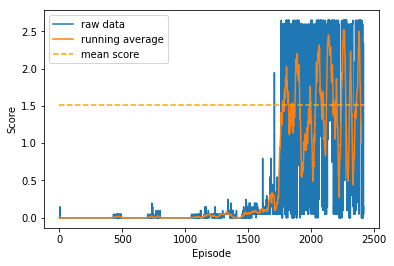

In [12]:
# plot the scores
data = np.genfromtxt("DDPG_scores.out")

N = 20
conv_data = data[-400:]
avg_score = np.mean(conv_data)
smooth_data = np.convolve(data, np.ones(N)/N, mode='valid')
t = np.linspace(0,len(data),len(data))

mean_x_vals = [0,len(data)]
mean_y_vals = [avg_score,avg_score]

plt.figure()
plt.plot(data, label='raw data')
plt.plot(smooth_data, label='running average')
plt.plot(mean_x_vals, mean_y_vals, color='orange', linestyle='--', label='mean score')
plt.xlabel("Episode")
plt.ylabel("Score")
plt.legend()
plt.show()
plt.savefig("DDPG_scores.png")
plt.close()

In [13]:
env.close()